In [1]:
import torch
import torch.nn.functional as F
import os
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torch import nn
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from dataset import DocDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2

In [2]:
transformations = A.Compose(
    [A.Flip(0.1),A.Rotate(p=0.6),A.Resize(height=320, width=480)
                                                                                                                          ],
    additional_targets={'image0': 'image'}
)


x_transformations = A.Compose([A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.4),A.RandomShadow(p=0.1)])

dataset = DocDataset(transforms=transformations,x_transforms=x_transformations)

In [ ]:
x = dataset[0][0]
plt.imshow(x,cmap='gray')

In [3]:
batch_size = 32
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [2]:
class DocEncoder(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.act = nn.LeakyReLU(0.1)
                      
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        
        self.pool = nn.MaxPool2d(2,2)
        
        
        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.up = nn.ConvTranspose2d(64,64,3,stride=2,padding=1, output_padding=1)
        
        self.conv5 = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        self.out = torch.nn.Sigmoid()     
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.bn2(x)
        x = self.act(x)
        x = self.conv4(x)
        x = self.act(x)
        x = self.up(x)
        x = self.act(x)
        x = self.conv5(x)
        x = self.out(x)
        
        return x
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        op = self.forward(x)
        loss= F.mse_loss(op, y)
        self.log('train_loss', loss,on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        op = self.forward(x)
        loss= F.mse_loss(op, y)
        self.log('val_loss', loss,on_step=False, on_epoch=True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return optimizer
        
    
    


In [5]:
model = DocEncoder()
trainer = pl.Trainer(gpus=1, max_epochs=500)
trainer.fit(model, train_loader, val_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

   | Name  | Type            | Params
-------------------------------------------
0  | conv1 | Conv2d          | 640   
1  | bn1   | BatchNorm2d     | 128   
2  | act   | LeakyReLU       | 0     
3  | conv2 | Conv2d          | 36.9 K
4  | pool  | MaxPool2d       | 0     
5  | conv3 | Conv2d          | 36.9 K
6  | bn2   | BatchNorm2d     | 128   
7  | conv4 | Conv2d          | 36.9 K
8  | up    | ConvTranspose2d | 36.9 K
9  | conv5 | Conv2d          | 577   
10 | out   | Sigmoid         | 0     
-------------------------------------------
149 K     Trainable params
0         Non-trainable params
149 K     Total params
0.597     Total estimated model params size (MB)
/home/anirudh/.pyenv/versions/3.7.4/envs/3.7sign_lang/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the

/home/anirudh/.pyenv/versions/3.7.4/envs/3.7sign_lang/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

In [108]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2894), started 13:39:24 ago. (Use '!kill 2894' to kill it.)

In [3]:
model = DocEncoder.load_from_checkpoint("best_model.ckpt")
model.eval()

DocEncoder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): LeakyReLU(negative_slope=0.1)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv5): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (out): Sigmoid()
)

In [33]:
test_t = A.Compose([A.Resize(height=320, width=480)])
test_dataset  = DocDataset(mode='test',transforms=test_t)
x = test_dataset[0][0].unsqueeze(0)
op = model(x)
x.dtype

torch.float32

In [6]:
%matplotlib inline
def op_visualize(x,op):
    plt.figure(figsize=(20,10))
    o_img = op.detach().cpu().numpy().squeeze(0)
    o_img = o_img.transpose(1,2,0)
    o_img = np.clip(o_img, 0, 1)
    x = x.detach().cpu().numpy().squeeze(0)
    x = x.transpose(1,2,0)
    plt.imshow(x,cmap='gray')
    plt.show()
    plt.figure(figsize=(20,10))
    plt.imshow(o_img,cmap='gray')
    
    

In [ ]:
op_visualize(x,y)

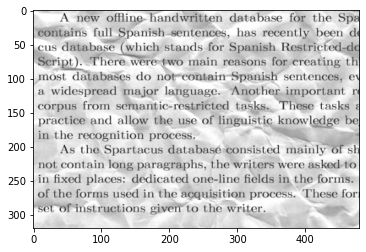

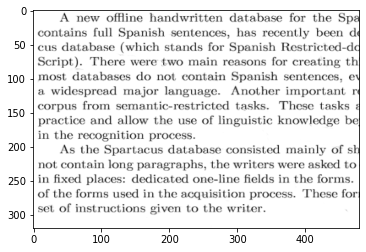

In [9]:
op_visualize(x,op)